### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 🐎 Notesbook at a Glance</p>

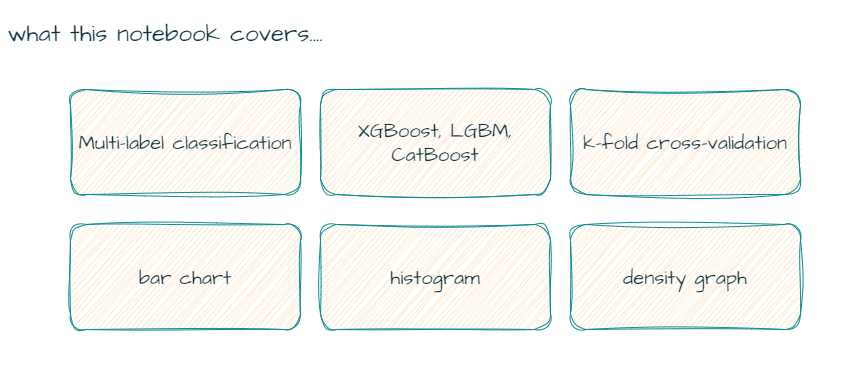

> #### * we covers multi-class classification (not multi-label classification)

In [ ]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re as re
from collections import Counter

from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

import time
from xgboost import XGBClassifier
%matplotlib inline
tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 🦄 Brief EDA</p>

In [ ]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train).style.background_gradient(cmap='YlOrBr')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 About Dataset:</font></h3>

<ul>
    <li><b>Objective</b>: The dataset aims to predict whether a horse can survive based on past medical conditions.</li>
    <li><b>Outcome</b>: Noted by the "outcome" variable. Possibilities include: lived, died, was euthanized.</li>
    <li><b>Missing Values</b>: The dataset contains a significant number of NA values, emphasizing the importance of data imputation in the preprocessing steps.</li>
    <li><b>Attributes</b>: The dataset provides a mix of categorical and linear (numeric) variables, covering a variety of clinical measurements, subjective judgments, and explicit medical findings. In total, there are 28 attributes to consider, with the 'outcome' being the target variable.</li>
    <li><b>Special Notes</b>: Some attributes, such as 'pain', should not be treated as ordered or discrete. Others, like 'type of lesion', break down into several sub-categories.</li>
    <li><b>Contextual Information</b>: Certain parameters, like 'rectal temperature' and 'pulse', offer specific context into the condition of the horse, such as potential infections or shock.</li>
    <li><b>Significant Attributes</b>: Parameters like 'abdominal distension' and 'nasogastric reflux' provide crucial indications about the horse's health and potential need for surgical interventions.</li>
</ul>

This summary offers a detailed initial understanding of the dataset's characteristics, assisting in making informed decisions in the subsequent analysis and modeling steps.
</div>


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Dataset Attributes Description:</font></h3>

<table border="1" cellpadding="5" cellspacing="0">
    <thead>
        <tr>
            <th>Attribute</th>
            <th>Description</th>
            <th>Values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>surgery?</td>
            <td>Whether the horse had surgery</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
        <tr>
            <td>Age</td>
            <td>Age category of the horse</td>
            <td>1 = Adult, 2 = Young (&lt; 6 months)</td>
        </tr>
        <tr>
            <td>Hospital Number</td>
            <td>Case number assigned to the horse</td>
            <td>Numeric ID</td>
        </tr>
        <tr>
            <td>rectal temperature</td>
            <td>Temperature in degrees celsius</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>pulse</td>
            <td>Heart rate in beats per minute</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>respiratory rate</td>
            <td>Rate of respiration</td>
            <td>Linear</td>
        </tr>
        <tr>
            <td>temperature of extremities</td>
            <td>Indication of peripheral circulation</td>
            <td>1 = Normal, 2 = Warm, 3 = Cool, 4 = Cold</td>
        </tr>
        <tr>
            <td>peripheral pulse</td>
            <td>Subjective assessment of peripheral pulse</td>
            <td>1 = Normal, 2 = Increased, 3 = Reduced, 4 = Absent</td>
        </tr>
        <tr>
            <td>mucous membranes</td>
            <td>Measurement of color of mucous membranes</td>
            <td>1-6 as described in the given data</td>
        </tr>
        <tr>
            <td>capillary refill time</td>
            <td>Clinical judgment of capillary refill time</td>
            <td>1 = &lt; 3 seconds, 2 = &gt;= 3 seconds</td>
        </tr>
        <!-- ... Rest of the rows for each attribute ... -->
        <tr>
            <td>abdominocentesis appearance</td>
            <td>Appearance of fluid from abdominocentesis</td>
            <td>1 = Clear, 2 = Cloudy, 3 = Serosanguinous</td>
        </tr>
        <tr>
            <td>abdomcentesis total protein</td>
            <td>Total protein from abdominocentesis</td>
            <td>Linear (gms/dL)</td>
        </tr>
        <tr>
            <td>outcome</td>
            <td>Final outcome for the horse</td>
            <td>1 = Lived, 2 = Died, 3 = Euthanized</td>
        </tr>
        <tr>
            <td>surgical lesion?</td>
            <td>If the lesion was surgical</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
        <tr>
            <td>type of lesion</td>
            <td>Type of lesion identified</td>
            <td>Comprehensive description given (Multiple layers)</td>
        </tr>
        <tr>
            <td>cp_data</td>
            <td>Presence of pathology data for the case</td>
            <td>1 = Yes, 2 = No</td>
        </tr>
    </tbody>
</table>

</div>



> ### 📊 Target variable distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = train

def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
    # Set background color
    plt.rcParams['figure.facecolor'] = '#FFFAF0'
    
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90, frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size': 13, 
        'weight': 'bold', 
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name}', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_count(df, 'outcome', 'Target Variable(Outcome) Distribution')

In [ ]:
# Unique value counts for each column
unique_counts = train.nunique()

# Threshold to distinguish continuous and categorical
threshold = 10

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

> ### 📊 Variables distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, len(continuous_vars) * 2.5))

for idx, column in enumerate(continuous_vars):
    # Plotting for outcome
    plt.subplot(len(continuous_vars), 2, idx*2+1)
    sns.histplot(x=column, hue="outcome", data=df, bins=30, kde=True, palette='YlOrRd')
    plt.title(f"{column} Distribution for outcome")
    plt.ylim(0, df[column].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, len(categorical_vars)*2.5))

for idx, column in enumerate(categorical_vars):
    plt.subplot(len(categorical_vars)//2 + len(categorical_vars) % 2, 2, idx+1)
    sns.countplot(x=column, hue="outcome", data=df, palette='YlOrRd')
    plt.title(f"{column} Countplot by outcome")
    plt.ylim(0, df[column].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Recommendations on Variables:</font></h3>
    
* A plethora of variables seem to manifest a substantial distinctive power in the dataset. However, the untreated missing values can obscure their true potential or influence. Addressing these missing values is of paramount importance for an accurate assessment and leveraging of these variables.

* Special attention should be paid to variables like 'lesion'. A meticulous preprocessing approach for such variables can not only enhance their utility but also prevent potential pitfalls or biases in the model's predictions.

</div>

> ### 📊 correlation

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataframe
df_encoded = train.copy()

# Assuming these are your categorical variables, including 'outcome'
categorical_vars = ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 
                    'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 
                    'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 
                    'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 
                    'cp_data', 'outcome']

# Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df[column])
    label_encoders[column] = le

def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    excluded_columns = ['id']
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    corr = df[columns_without_excluded].corr()
    
    fig, axes = plt.subplots(figsize=(14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

# Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df_encoded, 'Encoded Dataset Correlation')



<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 About Dataset:</font></h3>

<ul>
    Using label encoding to calculate the correlation for categorical variables has some caveats:
    <li><b>Arbitrary Ordering: </b> Label encoding assigns arbitrary numeric values to categorical data. These numbers might not have any inherent relationship with the original meaning of the data. Hence, when interpreting the correlation coefficient, this must be taken into account.</li>
    <li><b>Interpreting Correlation: </b> The correlation among label-encoded categorical variables might not accurately reflect the actual relationships between the variables. Especially if the order of the labels does not align with the true meaning of the data, caution in interpretation is required.</li>
    <li><b>Alternative Methods: </b>There are other statistical methods or techniques (e.g., Chi-squared test) that can be used to understand relationships between categorical data.</li>
   
</ul>

In summary, caution is needed when interpreting the correlation of label-encoded categorical variables. This approach might not represent the true relationship in the data, so it's better used as a reference in data exploration or preprocessing rather than for direct interpretation.
</div>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🔩 basic feature engineering and baseline modeling</p>

<div style="border-radius:10px; border:#b2d790 solid; padding: 15px; background-color: #d9ebc8; font-size:100%; text-align:left">
<h3 align="left"><font color='#d79190'>💡 Multi-class vs Multi-label: A Closer Look</font></h3>
The difference between multi-label classification and multi-class classification is as follows:
<br><br>
<b>Multi-label Classification:</b><br> Multi-label classification deals with scenarios where each data instance can be assigned to multiple labels or classes. This means that a single data point can belong to multiple classes simultaneously. For example, in image classification, an image may contain multiple objects, and the task is to recognize and classify all of these objects simultaneously. This problem is tackled using multi-label classification.
<br><br>
<b>Multi-class Classification:</b><br> Multi-class classification, on the other hand, deals with scenarios where each data instance can be assigned to only one class out of several possible classes. Each data point is assigned to a single class exclusively. For example, in digit recognition for handwritten digits, each digit is considered as a separate class, and the task is to classify each digit image into its corresponding class. This problem is tackled using multi-class classification.
<br><br>
In the given problem, it is a multi-class problem. 

<br><br>

</div>

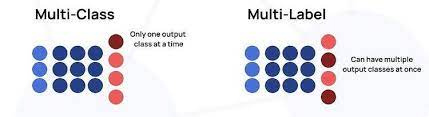

Image source: Analytics Vidhya


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion(y_pred, y_true):
    # Assuming y_true and y_pred are numpy arrays
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


> ### 📊 Simple pre-processing

In [ ]:
# very very simple pre-processing
for col in categorical_vars:
    df[col] = df[col].fillna(df[col].mode()[0])

for col in continuous_vars:
    df[col] = df[col].fillna(df[col].median())

# change categorical variables to number
label_encoders = {}
for col in categorical_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# outcome is our target variable
target_cols = ['outcome']
features = df.drop(columns=['id', 'outcome']).columns.tolist()

> ### 📊 Modeling

In [ ]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

# Modified hyperparameters
lgb_params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'lambda_l1': 5e-07,
    'lambda_l2': 0.001,
    'num_leaves': 32,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'min_child_samples': 45,
    'num_iterations': 5000,
    'learning_rate': 0.2
}

xgb_params = {
    'n_estimators': 5000,
    'n_jobs': -1,
    'max_depth': 5,
    'eta': 0.2,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'num_class': 3,
    'alpha': 8e-07,
    'lambda': 0.0012
}

cat_params = {
    'n_estimators': 5000,
    'depth': 5,
    'learning_rate': 0.2,
    'verbose': 0,
    'l2_leaf_reg': 0.0015
}


# Create models for each target
models = {
    'xgb': {target: XGBClassifier(**xgb_params) for target in target_cols},
    'lgb': {target: LGBMClassifier(**lgb_params) for target in target_cols},
    'cat': {target: CatBoostClassifier(**cat_params) for target in target_cols}
}

# Dictionaries to store results
oof = {model: {target: [] for target in target_cols} for model in models.keys()}
f1_scores = {model: {target: [] for target in target_cols} for model in models.keys()}
best_iters = {model: {target: [] for target in target_cols} for model in models.keys()}
best_models = {model: {target: None for target in target_cols} for model in models.keys()}
best_f1 = {model: {target: 0 for target in target_cols} for model in models.keys()}


# Training parameters
FOLDS = 5
SEED = 1004
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Train models
for model_name, model_dict in models.items():
    print(f'\033[1;34mTraining {model_name} models\033[0m')  # Blue for model names
    for target in target_cols:
        print(f'\033[1;32mTraining model for {target}\033[0m')  # Green for targets
        y = df[target]
        for fold, (train_idx, val_idx) in enumerate(skf.split(df, y)):
            print(f'\033[1;33m######################## Training FOLD {fold+1} ########################\033[0m')  # Yellow for fold numbers
            X_train, y_train = df.iloc[train_idx][features], y.iloc[train_idx]
            X_valid, y_valid = df.iloc[val_idx][features], y.iloc[val_idx]
            
            model = model_dict[target]
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=300, verbose=0)
            
            val_preds = model.predict(X_valid)
            val_score = f1_score(y_valid, val_preds, average='micro')
            
            print(f'\033[1;35mMicro F1-Score: {val_score:.5f}\033[0m')  # Purple for F1-Scores
            oof[model_name][target].append(val_preds)
            f1_scores[model_name][target].append(val_score)  # Rename auc_scores to f1_scores for clarity
            
            if model_name == 'xgb':  # XGBoost
                best_iters[model_name][target].append(model.get_booster().best_ntree_limit)
            elif model_name == 'lgb':  # LightGBM
                best_iters[model_name][target].append(model.best_iteration_)
            
            # Save the best model
            if val_score > best_f1[model_name][target]:
                best_f1[model_name][target] = val_score  # Rename best_auc to best_f1 for clarity
                best_models[model_name][target] = model
        
        print(f'\033[1;31m*********************************************\033[0m')  # Red for separator
        print(f'\033[1;35mMean Micro F1-Score for {target}: {np.mean(f1_scores[model_name][target]):.5f}\033[0m')  # Purple for mean F1-Scores


> ### 📊 evaluation and feature importance

In [ ]:
#code for evaulation and comparision + feature importance for each models.

for model_name, model_dict in best_models.items():
    for target in target_cols:
        print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        
        best_val_preds = model_dict[target].predict(df[features])
        f1 = f1_score(df[target], best_val_preds, average='micro')
        print(f'\033[1;35mMicro-averaged F1-Score: {f1:.5f}\033[0m')  # Purple for F1 scores

        # Confusion Matrix Visualization
        show_confusion(best_val_preds, df[target])

        # Feature Importance Visualization
        f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': model_dict[target].feature_importances_})
        f_importance_plot(f_imp_df)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Conclusions:</font></h3>

* This dataset warrants a thorough preprocessing approach for significant improvements. However, for illustrative purposes, I carried out a very basic preprocessing. This has likely contributed to the less-than-ideal micro-averaged F1 scores observed.

* The models were not subjected to hyperparameter tuning, which offers another avenue for substantial enhancements in performance.

* I would encourage further exploration and refinement, particularly in areas such as handling missing values, creating new derived features, and diving deeper into the data's intricacies. Building upon these insights could lead to model improvements and better predictive performance.

<div style="border-radius:10px; border:#b2d790 solid; padding: 15px; background-color: #d9ebc8; font-size:100%; text-align:left">
<h3 align="left"><font color='#d79190'>💡 Multiclass Classification Evaluation Method - Micro Average F1 Score: A Closer Look</font></h3>

* Micro Average F1 Score: In multiclass classification problems, the Micro Average F1 Score provides a comprehensive measure of a model's performance, especially when there's class imbalance. It considers every instance or prediction equally, regardless of the class. Specifically, it aggregates the contributions of all classes to compute the average metric.

* Example: Consider we have a multiclass classification problem where we predict animal types: Cats, Dogs, and Birds. Let's say the total number of instances are 1000, where:
True Cats: 800, Predicted Cats: 750
True Dogs: 100, Predicted Dogs: 125
True Birds: 100, Predicted Birds: 125
Using these numbers, we'd first calculate the overall true positives, false positives, and false negatives and then compute the F1 score. The micro-averaged F1 score would be a measure based on all 1000 instances.

* Class Imbalance Concerns: When datasets have an imbalanced class distribution, performance metrics can be skewed. In such cases, the Micro Average F1 Score proves valuable as it takes into account true positives, false positives, and false negatives from all classes to provide a holistic measure.

* Difference from Macro Average: While both are popular evaluation metrics for multiclass classification, they have distinct applications. Micro averages the performance on individual instances, making it less sensitive to class imbalance. On the other hand, Macro average treats each class equally, averaging the performance on a per-class basis. This means, if performance on a minority class is poor, it will reflect heavily on the Macro averaged result.

* Practical Implications: In real-world applications with imbalanced datasets, relying solely on metrics like accuracy or macro-averaged scores might be misleading. Micro Average F1 Score serves as a more consistent measure, ensuring that the model's performance is evaluated holistically across all instances and classes.

* Final Note: It's essential to choose the right evaluation metric based on the nature of the problem and the dataset at hand. Micro Average F1 Score stands out as a robust metric for datasets with varying class distributions, ensuring that every prediction, irrespective of its class, contributes equally to the final score.